In [16]:
from math import erfc, sqrt
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# --- Parameters ---

num_states = 8
pkt_bits = 1500 * 8  # packet of 1500 bytes
num_packets = 10000
rng = np.random.default_rng(seed=42)

In [18]:
# Transition matrix (Table 2, Wang & Moayeri)

transition_matrix = np.array([
    [0.795, 0.205, 0.0,   0.0,   0.0,   0.0,   0.0,   0.0  ],
    [0.042, 0.916, 0.042, 0.0,   0.0,   0.0,   0.0,   0.0  ],
    [0.0,   0.042, 0.916, 0.042, 0.0,   0.0,   0.0,   0.0  ],
    [0.0,   0.0,   0.042, 0.916, 0.042, 0.0,   0.0,   0.0  ],
    [0.0,   0.0,   0.0,   0.042, 0.916, 0.042, 0.0,   0.0  ],
    [0.0,   0.0,   0.0,   0.0,   0.042, 0.916, 0.042, 0.0  ],
    [0.0,   0.0,   0.0,   0.0,   0.0,   0.042, 0.916, 0.042],
    [0.0,   0.0,   0.0,   0.0,   0.0,   0.0,   0.205, 0.795]
])

In [19]:
# Actual SNR threshold of the article (in dB)

snr_boundaries_db = np.array([-np.inf, -1.59, 0.51, 2.12, 3.51, 4.77, 6.02, 7.29, np.inf])

In [20]:
assert num_states == len(snr_boundaries_db) - 1, "Number of states does not match SNR boundaries"

In [21]:
# midpoint of each band (to represent typical SNR)

state_snr_db = []
for i in range(num_states):
    if np.isinf(snr_boundaries_db[i]) or np.isinf(snr_boundaries_db[i+1]):
        # for infinite extremes, I use the finite value +1dB as an approximation
        if np.isinf(snr_boundaries_db[i]):
            mid = snr_boundaries_db[i+1] - 1.0
        else:
            mid = snr_boundaries_db[i] + 1.0
    else:
        mid = 0.5*(snr_boundaries_db[i] + snr_boundaries_db[i+1])
    state_snr_db.append(mid)
state_snr_db = np.array(state_snr_db)
state_snr_linear = 10 ** (state_snr_db / 10.0)

In [22]:
# BER for BPSK in AWGN
def ber_bpsk_awgn(snr_linear):
    return 0.5 * erfc(sqrt(snr_linear))

In [23]:
# PEP (Packet Error Probability) ---
def pep_from_ber(ber, L_bits):
    return 1.0 - (1.0 - ber) ** L_bits

In [24]:
state_ber = np.array([ber_bpsk_awgn(s) for s in state_snr_linear])
state_pep = np.array([pep_from_ber(b, pkt_bits) for b in state_ber])

In [25]:
print("State | SNR mid (dB) | BER(BPSK) | PEP ({} bits)".format(pkt_bits))
for i in range(num_states):
    print(f"{i:5d} |   {state_snr_db[i]:10.2f} | {state_ber[i]:.3e} | {state_pep[i]:.3e}")


State | SNR mid (dB) | BER(BPSK) | PEP (12000 bits)
    0 |        -2.59 | 1.470e-01 | 1.000e+00
    1 |        -0.54 | 9.193e-02 | 1.000e+00
    2 |         1.31 | 4.995e-02 | 1.000e+00
    3 |         2.81 | 2.526e-02 | 1.000e+00
    4 |         4.14 | 1.137e-02 | 1.000e+00
    5 |         5.39 | 4.246e-03 | 1.000e+00
    6 |         6.65 | 1.172e-03 | 1.000e+00
    7 |         8.29 | 1.199e-04 | 7.628e-01


In [26]:
# simulation of the transmissions according to the Markov chain
current_state = 3
failures = 0

transitions = []
for _ in range(num_packets):
    pep = state_pep[current_state]
    success = rng.random() > pep
    if not success:
        failures += 1
    transitions.append((current_state, success))

    # next state
    current_state = rng.choice(range(num_states), p=transition_matrix[current_state])

print(f"\nSimulação: {num_packets} pacotes, falhas = {failures}, perda = {failures/num_packets:.4f}")


Simulação: 10000 pacotes, falhas = 9908, perda = 0.9908


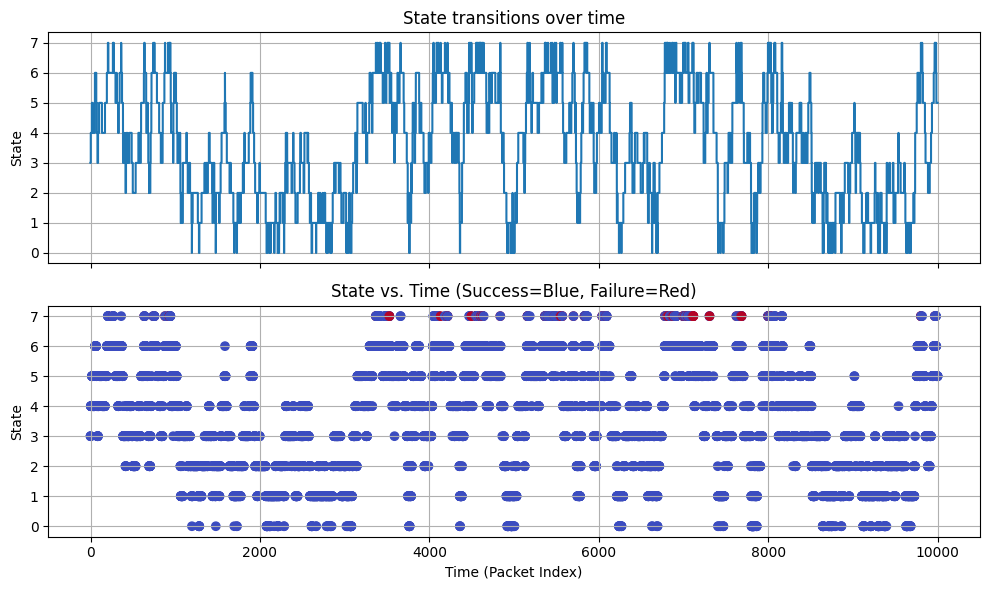

In [28]:
times = np.arange(len(transitions))
states = [s for s, _ in transitions]
successes = [succ for _, succ in transitions]

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Step plot: state transitions over time
axs[0].step(times, states, where='post')
axs[0].set_ylabel('State')
axs[0].set_title('State transitions over time')
axs[0].grid(True)

# Scatter plot: state vs time, colored by success/failure
axs[1].scatter(times, states, c=successes, cmap='coolwarm', marker='o', label='Success/Failure')
axs[1].set_ylabel('State')
axs[1].set_xlabel('Time (Packet Index)')
axs[1].set_title('State vs. Time (Success=Blue, Failure=Red)')
axs[1].grid(True)

for ax in axs:
    ax.yaxis.set_major_locator(plt.MultipleLocator(1.0))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:g}'.format(int(x))))

plt.tight_layout()
plt.show()

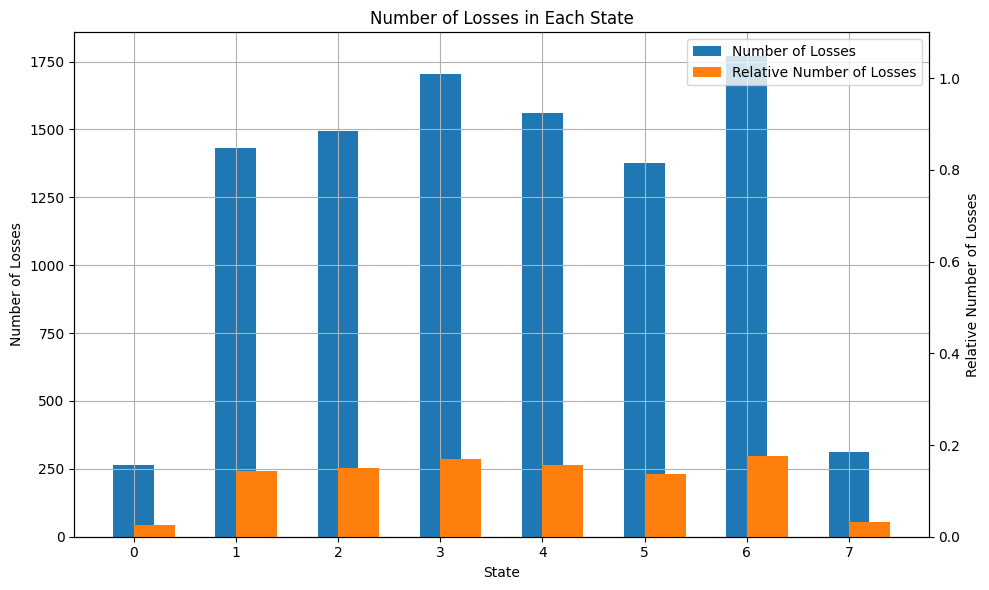

In [41]:
# number of losses in each state
losses_in_state = [sum([s==i and not succ for s, succ in transitions]) for i in range(num_states)]
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(range(num_states), losses_in_state, width=0.4)
ax.set_xlabel('State')
ax.set_ylabel('Number of Losses')
ax.set_title('Number of Losses in Each State')
ax.grid(True)

ax2 = ax.twinx()
bar2 = ax2.bar([x + 0.2 for x in range(num_states)], [loss/num_packets for loss in losses_in_state], color='tab:orange', width=0.4)
ax2.set_ylabel('Relative Number of Losses')
ax2.set_ylim([0, 1.1])
ax2.grid(False)

plt.legend([bar1, bar2], ['Number of Losses', 'Relative Number of Losses'], loc='best')
plt.tight_layout()
plt.show()